In [69]:
# Importing the usual libraries, including MinMaxScaler to scale values, Dropout to handle overfitting
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
%matplotlib inline

In [70]:
# Random seed set at 5 for protyping the model. Will experiment w/other numbers.
from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(5)

In [71]:
# Grab data from csv and display
stock_df = pd.read_csv(
    Path("stock_data_yrb.csv"),
    index_col="Date",
    infer_datetime_format=True,
    parse_dates=True,
)
stock_df.head()

,TSLA,F,GM,SPX
Date,,,,
2021-07-02,$678.9,$14.93,$58.96,4352.34
2021-07-01,$677.92,$14.91,$59.11,4319.94
2021-06-30,$679.7,$14.86,$59.17,4297.50
2021-06-29,$680.76,$15.01,$58.83,4291.80
2021-06-28,$688.72,$14.96,$58.64,4290.61


In [72]:
# Clearing any nulls from stock_df
stock_data = stock_df.dropna().copy()
stock_data

,TSLA,F,GM,SPX
Date,,,,
2021-07-02,$678.9,$14.93,$58.96,4352.34
2021-07-01,$677.92,$14.91,$59.11,4319.94
2021-06-30,$679.7,$14.86,$59.17,4297.50
2021-06-29,$680.76,$15.01,$58.83,4291.80
2021-06-28,$688.72,$14.96,$58.64,4290.61
...,...,...,...,...
2016-07-11,$44.956,$13.27,$30.13,2152.14
2016-07-08,$43.356,$13.09,$29.66,2137.16
2016-07-07,$43.188,$12.75,$28.74,2129.90


In [73]:
# Erasing the "$" from the database
stock_data["TSLA"]= stock_data["TSLA"].str.replace("$", "")
stock_data["F"]= stock_data["F"].str.replace("$", "")
stock_data["GM"]= stock_data["GM"].str.replace("$", "")
stock_data


,TSLA,F,GM,SPX
Date,,,,
2021-07-02,678.9,14.93,58.96,4352.34
2021-07-01,677.92,14.91,59.11,4319.94
2021-06-30,679.7,14.86,59.17,4297.50
2021-06-29,680.76,15.01,58.83,4291.80
2021-06-28,688.72,14.96,58.64,4290.61
...,...,...,...,...
2016-07-11,44.956,13.27,30.13,2152.14
2016-07-08,43.356,13.09,29.66,2137.16
2016-07-07,43.188,12.75,28.74,2129.90


In [74]:
# Confirm data types
stock_data.dtypes

TSLA     object
F        object
GM       object
SPX     float64
dtype: object

# Use closing price of each stock to predict future closing price. 
## Create numpy arrays of input feature vector x and target vector y

In [75]:
# Grabbing the dataframe, features and target, returning the X vector array and the y target vector array
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for info in range(len(df) - window):
        features = df.iloc[info : (info + window), feature_col_number]
        target = df.iloc[(info + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [76]:
# Using X features and y target with window_data() function.
# Choosing the features and target column number to 3, because this is the SPX column.
window_size = 5

feature_column = 3
target_column = 3
X, y = window_data(stock_df, window_size, feature_column, target_column)
print (f"X features:\n{X[:5]} \n")
print (f"y target:\n{y[:5]}")

X features:
[[4352.34 4319.94 4297.5  4291.8  4290.61]
 [4319.94 4297.5  4291.8  4290.61 4280.7 ]
 [4297.5  4291.8  4290.61 4280.7  4266.49]
 [4291.8  4290.61 4280.7  4266.49 4241.84]
 [4290.61 4280.7  4266.49 4241.84 4246.44]] 

y target:
[[4280.7 ]
 [4266.49]
 [4241.84]
 [4246.44]
 [4224.79]]


In [77]:
# Split data - 70% = training, 30% = testing - to stop randomizing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [78]:
# Scaling features and target between 0 and 1 using MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [79]:
# Training and testing are reshaped here so that the Keras API can accept the data 
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]]

 [[0.98570899]
  [0.98995865]
  [0.99742352]
  [0.99946071]
  [0.99550655]]

 [[0.97581115]
  [0.98740804]
  [0.99688562]
  [0.99496968]
  [0.98906336]]

 [[0.97329699]
  [0.98687555]
  [0.99240616]
  [0.98852997]
  [0.9778864 ]]

 [[0.9727721 ]
  [0.98244107]
  [0.98598304]
  [0.97735904]
  [0.97997216]]] 

X_test sample values:
[[[0.29222904]
  [0.29442535]
  [0.28875118]
  [0.28454378]
  [0.27687571]]

 [[0.29021772]
  [0.28585172]
  [0.28381066]
  [0.2767264 ]
  [0.26680965]]

 [[0.28176662]
  [0.28096082]
  [0.27601342]
  [0.26666576]
  [0.27312588]]

 [[0.27694561]
  [0.27324187]
  [0.2659787 ]
  [0.27297858]
  [0.27089502]]

 [[0.26933697]
  [0.26330792]
  [0.27227526]
  [0.27074893]
  [0.26993375]]]


## Creating a LSTM RNN Model Structure

In [80]:
# Defining the LSTM model, adding a LSTM layer 1, 2, and 3, and finally, adding an output layer
# Every LSTM layer has the same number of units as the window size: 5 
lstm_model = Sequential()

number_units = 5
dropout_fraction = 0.2
# First layer: 
lstm_model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
lstm_model.add(Dropout(dropout_fraction))
# Second layer:
lstm_model.add(LSTM(units=number_units, return_sequences=True))
lstm_model.add(Dropout(dropout_fraction))
# Third layer:
lstm_model.add(LSTM(units=number_units))
lstm_model.add(Dropout(dropout_fraction))
# Final output layer:
lstm_model.add(Dense(1))

## Compile and summarize the model to define it

In [81]:
# User optimzer = "adam", loss function = mean squared error, for continuous predictions
lstm_model.compile(optimizer="adam", loss="mean_squared_error")
 
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 5)              140       
_________________________________________________________________
dropout (Dropout)            (None, 5, 5)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 5)              220       
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5)                 220       
_________________________________________________________________
dropout_2 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 6

In [82]:
# Train the LSTM model with 10 epochs - will keep batch size at 1, will experiment with larger batch
# sizes if time warrants
lstm_model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
878/878 [==============================] - 9s 4ms/step - loss: 0.0663
Epoch 2/10
878/878 [==============================] - 4s 4ms/step - loss: 0.0179
Epoch 3/10
878/878 [==============================] - 4s 5ms/step - loss: 0.0121
Epoch 4/10
878/878 [==============================] - 4s 5ms/step - loss: 0.0111
Epoch 5/10
878/878 [==============================] - 4s 5ms/step - loss: 0.0091
Epoch 6/10
878/878 [==============================] - 4s 4ms/step - loss: 0.0078
Epoch 7/10
878/878 [==============================] - 4s 5ms/step - loss: 0.0066
Epoch 8/10
878/878 [==============================] - 4s 5ms/step - loss: 0.0071
Epoch 9/10
878/878 [==============================] - 4s 4ms/step - loss: 0.0062
Epoch 10/10
878/878 [==============================] - 4s 4ms/step - loss: 0.0060


## Part I - Evaluate the LSTM model by applying the X and y data, predict price using X data
## Part II - Compare the y test and predicted values, setup a dataframe
## Part III - From the real and predicted values, plot a line chart

In [87]:
# Part I:
lstm_model.evaluate(X_test, y_test)

12/12 [==============================] - 0s 3ms/step - loss: 0.0287


0.028681742027401924

In [88]:
lstm_predicted = lstm_model.predict(X_test)

In [89]:
# Bring the scaled values back to their original prices, so we can analyze the predictions
predicted_value = scaler.inverse_transform(lstm_predicted)
original_price = scaler.inverse_transform(y_test.reshape(-1, 1))

In [91]:
# Part II:
lstm_stocks = pd.DataFrame({
    "Real": original_price.ravel(),
    "Predicted": predicted_value.ravel()
    }, index = stock_df.index[-len(original_price): ])
lstm_stocks.head()

,Real,Predicted
Date,,
2017-12-28,2673.61,2775.450928
2017-12-27,2687.54,2772.331543
2017-12-26,2682.62,2768.498535
2017-12-22,2680.50,2765.604980
2017-12-21,2683.34,2763.121582


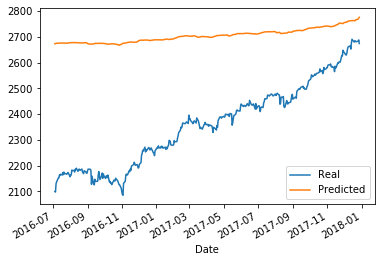

In [93]:
lstm_stocks.plot()